In [ ]:
token
lstm
embedding
relation

In [181]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import jieba

In [283]:
train_original = [
    ('我之前在安徽，现在刚刚搬到苏州', 'request_location', '苏州'),
    ('我今年刚满20岁', 'request_age', '20'),
    ('我去年18岁，今年19岁', 'request_age', '19'),
    ('我今年19岁，去年18岁', 'request_age', '19'),
]
test_original = [
    ('我去年19岁，今年20岁', 'request_age', '20'),
    ('我去年10岁，今年11岁', 'request_age', '11'),
    ('我今年11岁，去年10岁', 'request_age', '11'),
    ('我去年10岁，但11岁了今年', 'request_age', '11'),
]
train = []
for x, q, y in train_original:
    tokens = list(jieba.cut(x, cut_all = False))
    train.append((tokens, q, tokens.index(y)))
test = []
for x, q, y in test_original:
    tokens = list(jieba.cut(x, cut_all = False))
    test.append((tokens, q, tokens.index(y)))
print(train)
print(test)

[(['我', '之前', '在', '安徽', '，', '现在', '刚刚', '搬', '到', '苏州'], 'request_location', 9), (['我', '今年', '刚满', '20', '岁'], 'request_age', 3), (['我', '去年', '18', '岁', '，', '今年', '19', '岁'], 'request_age', 6), (['我', '今年', '19', '岁', '，', '去年', '18', '岁'], 'request_age', 2)]
[(['我', '去年', '19', '岁', '，', '今年', '20', '岁'], 'request_age', 6), (['我', '去年', '10', '岁', '，', '今年', '11', '岁'], 'request_age', 6), (['我', '今年', '11', '岁', '，', '去年', '10', '岁'], 'request_age', 2), (['我', '去年', '10', '岁', '，', '但', '11', '岁', '了', '今年'], 'request_age', 6)]


In [284]:
word_to_ix = {'NUM': 0}
for sent, question, tags in train + test:
    for word in sent:
        if word.isnumeric():
            continue
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)

{'NUM': 0, '我': 1, '之前': 2, '在': 3, '安徽': 4, '，': 5, '现在': 6, '刚刚': 7, '搬': 8, '到': 9, '苏州': 10, '今年': 11, '刚满': 12, '岁': 13, '去年': 14, '但': 15, '了': 16}


In [288]:
class relation_network(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(relation_network, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden = self.init_hidden()
        # first mlp: 4 layers, 256 each, Relu
        # hidden_dim + hidden_dim + 1
        self.mlp_relation1 = nn.Linear(2 * hidden_dim + 3, 20)
        self.mlp_relation2 = nn.Linear(20, 20)
#         self.mlp_relation3 = nn.Linear(256, 256)
#         self.mlp_relation4 = nn.Linear(256, 256)
        
        #second mlp: 3 layers, 256, 256, 1, Relu
        self.mlp_answer1 = nn.Linear(20, 10)
#         self.mlp_answer2 = nn.Linear(256, 256)
        self.mlp_answer3 = nn.Linear(10, 1)
        
    
    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))
    
    def forward(self, sentence, question):
        embeds = self.embedding(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        lstm_out = lstm_out.view(len(sentence), -1)
        list_relation = []
        for i in range(len(lstm_out)):
            for j in range(i):
                relation_vec = torch.cat((lstm_out[i].view(1, -1), lstm_out[j].view(1, -1), question.view(1, -1)), 1)
                # relation mlp
                hidden1 = self.mlp_relation1(relation_vec)
                hidden2 = self.mlp_relation2(hidden1)
#                 hidden3 = self.mlp_relation3(hidden2)
#                 hidden4 = self.mlp_relation4(hidden3)
                hidden = F.relu(hidden2)
                list_relation.append(hidden)
        list_relation = torch.cat(list_relation, 0)
        relation = torch.sum(list_relation, dim = 0)
        # answer mlp
        hidden1 = self.mlp_answer1(relation)
#         hidden2 = self.mlp_answer2(hidden1)
        hidden3 = self.mlp_answer3(hidden1)
        answer = F.relu(hidden3)
        return answer

In [188]:
def prepare(seq, question, answer, to_idx):
    Q = {
        'request_age': [0, 0, 1],
        'request_location': [0, 1, 0],
        'request_degree': [1, 0, 0]
    }
    idxs = [to_idx['NUM'] if w.isnumeric() else to_idx[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long), torch.tensor(Q[question], dtype = torch.float), torch.FloatTensor([answer])

In [289]:
EMBEDDING = 10
HIDDEN = 20
rn = relation_network(EMBEDDING, HIDDEN, len(word_to_ix))
optimizer = optim.SGD(rn.parameters(), lr=0.001)
loss_func = nn.MSELoss()

list_loss = []
for epoch in range(500):
    tmp_loss = 0
    for x, q, y in train:
#         print(x)
        rn.zero_grad()
        rn.hidden = rn.init_hidden()
        sentence, q, y = prepare(x, q, y, word_to_ix)
        answer = rn(sentence, q)
        print(y, answer)
        loss = loss_func(answer.view(1, -1), y.view(1, -1))
        tmp_loss += loss
#         print(loss)
        loss.backward()
        optimizer.step()
    list_loss.append(tmp_loss)

tensor([ 9.]) tensor([ 0.7354])
tensor([ 3.]) tensor([ 1.8650])
tensor([ 6.]) tensor([ 5.3159])
tensor([ 2.]) tensor([ 5.9366])
tensor([ 9.]) tensor([ 4.5463])
tensor([ 3.]) tensor([ 2.2005])
tensor([ 6.]) tensor([ 6.2000])
tensor([ 2.]) tensor([ 5.9966])
tensor([ 9.]) tensor([ 5.5265])
tensor([ 3.]) tensor([ 2.0508])
tensor([ 6.]) tensor([ 5.7563])
tensor([ 2.]) tensor([ 5.9486])
tensor([ 9.]) tensor([ 6.5153])
tensor([ 3.]) tensor([ 1.8403])
tensor([ 6.]) tensor([ 5.1539])
tensor([ 2.]) tensor([ 5.8065])
tensor([ 9.]) tensor([ 7.4938])
tensor([ 3.]) tensor([ 1.5916])
tensor([ 6.]) tensor([ 4.4432])
tensor([ 2.]) tensor([ 5.5204])
tensor([ 9.]) tensor([ 8.3137])
tensor([ 3.]) tensor([ 1.3774])
tensor([ 6.]) tensor([ 3.8153])
tensor([ 2.]) tensor([ 5.1212])
tensor([ 9.]) tensor([ 8.7998])
tensor([ 3.]) tensor([ 1.2654])
tensor([ 6.]) tensor([ 3.4744])
tensor([ 2.]) tensor([ 4.8307])
tensor([ 9.]) tensor([ 8.9516])
tensor([ 3.]) tensor([ 1.2472])
tensor([ 6.]) tensor([ 3.4118])
tensor([

tensor([ 2.]) tensor([ 3.6005])
tensor([ 9.]) tensor([ 9.0441])
tensor([ 3.]) tensor([ 1.8842])
tensor([ 6.]) tensor([ 4.9814])
tensor([ 2.]) tensor([ 3.5758])
tensor([ 9.]) tensor([ 9.0605])
tensor([ 3.]) tensor([ 1.8884])
tensor([ 6.]) tensor([ 5.0035])
tensor([ 2.]) tensor([ 3.5345])
tensor([ 9.]) tensor([ 9.0554])
tensor([ 3.]) tensor([ 1.9040])
tensor([ 6.]) tensor([ 5.0544])
tensor([ 2.]) tensor([ 3.4915])
tensor([ 9.]) tensor([ 9.0546])
tensor([ 3.]) tensor([ 1.9182])
tensor([ 6.]) tensor([ 5.1021])
tensor([ 2.]) tensor([ 3.4497])
tensor([ 9.]) tensor([ 9.0473])
tensor([ 3.]) tensor([ 1.9349])
tensor([ 6.]) tensor([ 5.1554])
tensor([ 2.]) tensor([ 3.4060])
tensor([ 9.]) tensor([ 9.0383])
tensor([ 3.]) tensor([ 1.9499])
tensor([ 6.]) tensor([ 5.2033])
tensor([ 2.]) tensor([ 3.3591])
tensor([ 9.]) tensor([ 9.0530])
tensor([ 3.]) tensor([ 1.9575])
tensor([ 6.]) tensor([ 5.2302])
tensor([ 2.]) tensor([ 3.3125])
tensor([ 9.]) tensor([ 9.0367])
tensor([ 3.]) tensor([ 1.9799])
tensor([

tensor([ 2.]) tensor([ 2.1140])
tensor([ 9.]) tensor([ 9.2741])
tensor([ 3.]) tensor([ 2.5103])
tensor([ 6.]) tensor([ 5.5128])
tensor([ 2.]) tensor([ 2.3878])
tensor([ 9.]) tensor([ 8.7628])
tensor([ 3.]) tensor([ 2.8881])
tensor([ 6.]) tensor([ 6.2925])
tensor([ 2.]) tensor([ 2.0625])
tensor([ 9.]) tensor([ 9.2614])
tensor([ 3.]) tensor([ 2.5460])
tensor([ 6.]) tensor([ 5.5573])
tensor([ 2.]) tensor([ 2.3409])
tensor([ 9.]) tensor([ 8.7565])
tensor([ 3.]) tensor([ 2.9223])
tensor([ 6.]) tensor([ 6.3260])
tensor([ 2.]) tensor([ 2.0073])
tensor([ 9.]) tensor([ 9.2722])
tensor([ 3.]) tensor([ 2.5617])
tensor([ 6.]) tensor([ 5.5589])
tensor([ 2.]) tensor([ 2.3169])
tensor([ 9.]) tensor([ 8.7320])
tensor([ 3.]) tensor([ 2.9662])
tensor([ 6.]) tensor([ 6.3803])
tensor([ 2.]) tensor([ 1.9529])
tensor([ 9.]) tensor([ 9.2950])
tensor([ 3.]) tensor([ 2.5640])
tensor([ 6.]) tensor([ 5.5335])
tensor([ 2.]) tensor([ 2.3115])
tensor([ 9.]) tensor([ 8.6951])
tensor([ 3.]) tensor([ 3.0124])
tensor([

tensor([ 2.]) tensor([ 1.9026])
tensor([ 9.]) tensor([ 9.2305])
tensor([ 3.]) tensor([ 2.7742])
tensor([ 6.]) tensor([ 5.6430])
tensor([ 2.]) tensor([ 2.1825])
tensor([ 9.]) tensor([ 8.7768])
tensor([ 3.]) tensor([ 3.1098])
tensor([ 6.]) tensor([ 6.3067])
tensor([ 2.]) tensor([ 1.9055])
tensor([ 9.]) tensor([ 9.2204])
tensor([ 3.]) tensor([ 2.7848])
tensor([ 6.]) tensor([ 5.6599])
tensor([ 2.]) tensor([ 2.1735])
tensor([ 9.]) tensor([ 8.7869])
tensor([ 3.]) tensor([ 3.1056])
tensor([ 6.]) tensor([ 6.2938])
tensor([ 2.]) tensor([ 1.9084])
tensor([ 9.]) tensor([ 9.2107])
tensor([ 3.]) tensor([ 2.7950])
tensor([ 6.]) tensor([ 5.6760])
tensor([ 2.]) tensor([ 2.1648])
tensor([ 9.]) tensor([ 8.7962])
tensor([ 3.]) tensor([ 3.1019])
tensor([ 6.]) tensor([ 6.2819])
tensor([ 2.]) tensor([ 1.9109])
tensor([ 9.]) tensor([ 9.2017])
tensor([ 3.]) tensor([ 2.8046])
tensor([ 6.]) tensor([ 5.6909])
tensor([ 2.]) tensor([ 2.1566])
tensor([ 9.]) tensor([ 8.8046])
tensor([ 3.]) tensor([ 3.0987])
tensor([

tensor([ 2.]) tensor([ 2.0609])
tensor([ 9.]) tensor([ 8.9118])
tensor([ 3.]) tensor([ 3.0573])
tensor([ 6.]) tensor([ 6.1255])
tensor([ 2.]) tensor([ 1.9512])
tensor([ 9.]) tensor([ 9.0873])
tensor([ 3.]) tensor([ 2.9275])
tensor([ 6.]) tensor([ 5.8707])
tensor([ 2.]) tensor([ 2.0593])
tensor([ 9.]) tensor([ 8.9139])
tensor([ 3.]) tensor([ 3.0561])
tensor([ 6.]) tensor([ 6.1226])
tensor([ 2.]) tensor([ 1.9523])
tensor([ 9.]) tensor([ 9.0852])
tensor([ 3.]) tensor([ 2.9294])
tensor([ 6.]) tensor([ 5.8739])
tensor([ 2.]) tensor([ 2.0577])
tensor([ 9.]) tensor([ 8.9160])
tensor([ 3.]) tensor([ 3.0550])
tensor([ 6.]) tensor([ 6.1197])
tensor([ 2.]) tensor([ 1.9533])
tensor([ 9.]) tensor([ 9.0831])
tensor([ 3.]) tensor([ 2.9313])
tensor([ 6.]) tensor([ 5.8770])
tensor([ 2.]) tensor([ 2.0562])
tensor([ 9.]) tensor([ 8.9180])
tensor([ 3.]) tensor([ 3.0538])
tensor([ 6.]) tensor([ 6.1168])
tensor([ 2.]) tensor([ 1.9543])
tensor([ 9.]) tensor([ 9.0811])
tensor([ 3.]) tensor([ 2.9332])
tensor([

tensor([ 9.]) tensor([ 8.9619])
tensor([ 3.]) tensor([ 3.0267])
tensor([ 6.]) tensor([ 6.0548])
tensor([ 2.]) tensor([ 1.9776])
tensor([ 9.]) tensor([ 9.0376])
tensor([ 3.]) tensor([ 2.9706])
tensor([ 6.]) tensor([ 5.9450])
tensor([ 2.]) tensor([ 2.0242])
tensor([ 9.]) tensor([ 8.9630])
tensor([ 3.]) tensor([ 3.0260])
tensor([ 6.]) tensor([ 6.0533])
tensor([ 2.]) tensor([ 1.9782])
tensor([ 9.]) tensor([ 9.0366])
tensor([ 3.]) tensor([ 2.9715])
tensor([ 6.]) tensor([ 5.9465])
tensor([ 2.]) tensor([ 2.0235])
tensor([ 9.]) tensor([ 8.9639])
tensor([ 3.]) tensor([ 3.0254])
tensor([ 6.]) tensor([ 6.0519])
tensor([ 2.]) tensor([ 1.9787])
tensor([ 9.]) tensor([ 9.0356])
tensor([ 3.]) tensor([ 2.9723])
tensor([ 6.]) tensor([ 5.9479])
tensor([ 2.]) tensor([ 2.0229])
tensor([ 9.]) tensor([ 8.9649])
tensor([ 3.]) tensor([ 3.0247])
tensor([ 6.]) tensor([ 6.0505])
tensor([ 2.]) tensor([ 1.9793])
tensor([ 9.]) tensor([ 9.0346])
tensor([ 3.]) tensor([ 2.9731])
tensor([ 6.]) tensor([ 5.9493])
tensor([

tensor([ 3.]) tensor([ 3.0115])
tensor([ 6.]) tensor([ 6.0230])
tensor([ 2.]) tensor([ 1.9904])
tensor([ 9.]) tensor([ 9.0157])
tensor([ 3.]) tensor([ 2.9881])
tensor([ 6.]) tensor([ 5.9772])
tensor([ 2.]) tensor([ 2.0099])
tensor([ 9.]) tensor([ 8.9845])
tensor([ 3.]) tensor([ 3.0112])
tensor([ 6.]) tensor([ 6.0224])
tensor([ 2.]) tensor([ 1.9906])
tensor([ 9.]) tensor([ 9.0153])
tensor([ 3.]) tensor([ 2.9884])
tensor([ 6.]) tensor([ 5.9778])
tensor([ 2.]) tensor([ 2.0096])
tensor([ 9.]) tensor([ 8.9850])
tensor([ 3.]) tensor([ 3.0109])
tensor([ 6.]) tensor([ 6.0218])
tensor([ 2.]) tensor([ 1.9909])
tensor([ 9.]) tensor([ 9.0149])
tensor([ 3.]) tensor([ 2.9887])
tensor([ 6.]) tensor([ 5.9784])
tensor([ 2.]) tensor([ 2.0093])
tensor([ 9.]) tensor([ 8.9854])
tensor([ 3.]) tensor([ 3.0106])
tensor([ 6.]) tensor([ 6.0212])
tensor([ 2.]) tensor([ 1.9911])
tensor([ 9.]) tensor([ 9.0145])
tensor([ 3.]) tensor([ 2.9891])
tensor([ 6.]) tensor([ 5.9790])
tensor([ 2.]) tensor([ 2.0091])
tensor([

tensor([ 9.]) tensor([ 9.0062])
tensor([ 3.]) tensor([ 2.9954])
tensor([ 6.]) tensor([ 5.9910])
tensor([ 2.]) tensor([ 2.0038])
tensor([ 9.]) tensor([ 8.9939])
tensor([ 3.]) tensor([ 3.0045])
tensor([ 6.]) tensor([ 6.0088])
tensor([ 2.]) tensor([ 1.9963])
tensor([ 9.]) tensor([ 9.0060])
tensor([ 3.]) tensor([ 2.9955])
tensor([ 6.]) tensor([ 5.9913])
tensor([ 2.]) tensor([ 2.0037])
tensor([ 9.]) tensor([ 8.9941])
tensor([ 3.]) tensor([ 3.0044])
tensor([ 6.]) tensor([ 6.0086])
tensor([ 2.]) tensor([ 1.9964])
tensor([ 9.]) tensor([ 9.0058])
tensor([ 3.]) tensor([ 2.9956])
tensor([ 6.]) tensor([ 5.9915])
tensor([ 2.]) tensor([ 2.0036])
tensor([ 9.]) tensor([ 8.9942])
tensor([ 3.]) tensor([ 3.0042])
tensor([ 6.]) tensor([ 6.0083])
tensor([ 2.]) tensor([ 1.9965])
tensor([ 9.]) tensor([ 9.0057])
tensor([ 3.]) tensor([ 2.9957])
tensor([ 6.]) tensor([ 5.9917])
tensor([ 2.]) tensor([ 2.0035])
tensor([ 9.]) tensor([ 8.9944])
tensor([ 3.]) tensor([ 3.0041])
tensor([ 6.]) tensor([ 6.0081])
tensor([

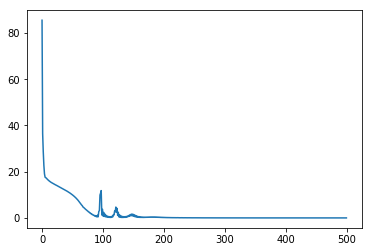

In [290]:
plt.plot(list_loss)

In [291]:
for x, q, y in test:
    sentence, q, y = prepare(x, q, y, word_to_ix)
    answer = rn(sentence, q)
    print(y, answer)

tensor([ 6.]) tensor([ 5.9895])
tensor([ 6.]) tensor([ 5.6947])
tensor([ 2.]) tensor([ 1.8396])
tensor([ 6.]) tensor([ 9.7634])
